In [47]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

In [90]:
# load data
df = pd.read_excel("../data/raw/Telco_customer_churn_adapted_v2.xlsx")
df_ori = df.copy()

In [91]:
df['Churn Label'].value_counts(normalize=True)*100

Churn Label
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64

26% of passengers churned from purchasing

# Background

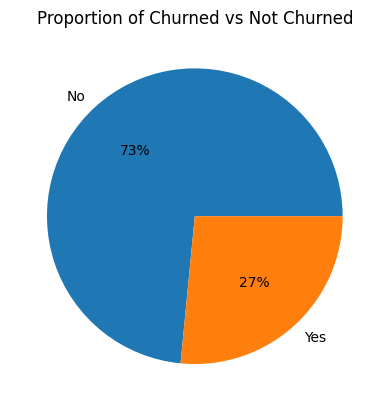

In [92]:
plot_df = df['Churn Label'].value_counts(normalize=True)*100
plt.pie(plot_df, labels=plot_df.index, autopct='%.0f%%')
plt.title("Proportion of Churned vs Not Churned")
plt.show()

26% of passengers churned from purchasing

In [93]:
display(df.groupby("Churn Label")["CLTV (Predicted Thou. IDR)"].sum())
display(df.groupby("Churn Label")["Monthly Purchase (Thou. IDR)"].sum())

Churn Label
No     30206835.1
Yes    10081832.8
Name: CLTV (Predicted Thou. IDR), dtype: float64

Churn Label
No     412081.475
Yes    180870.105
Name: Monthly Purchase (Thou. IDR), dtype: float64

Around `Rp10,081,832,800.00` potential income in the future will be gone.

Around `Rp180,870,800.00` strip out from the company's monthly income.

# EDA for Modelling

## Device Class

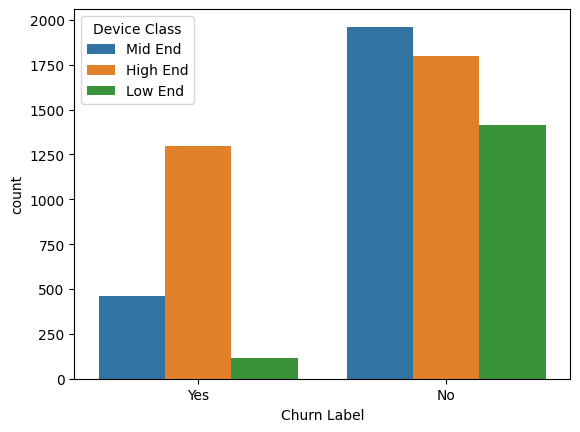

In [94]:
sns.countplot(data=df, x='Churn Label', hue='Device Class')
plt.show()

`~1250` customer who churned are from the high end class followed by mid (`~500`) and low (`~125`) end class.

In [95]:
churn_device = df.pivot_table(columns="Device Class", index='Churn Label', values="Customer ID", aggfunc="count", margins=True)
churn_device = churn_device/churn_device.loc['All', :]
churn_device = churn_device.loc[churn_device.index != 'All', churn_device.columns != 'All']
churn_device

Device Class,High End,Low End,Mid End
Churn Label,,,
No,0.581072,0.92595,0.810409
Yes,0.418928,0.07405,0.189591


high end class users have 40% change of churning, 18% are mid end class users, and 7% are from low end class users

## Location

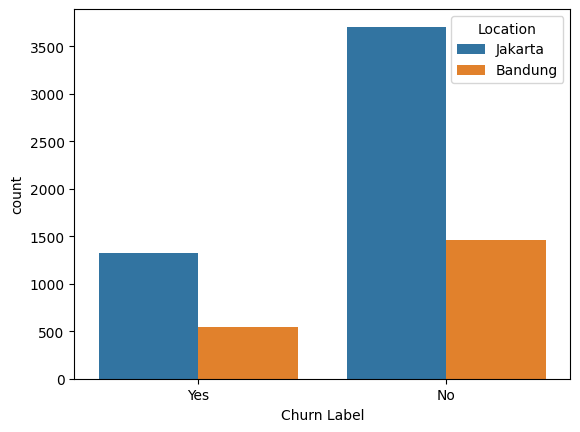

In [96]:
sns.countplot(data=df, x='Churn Label', hue='Location')
plt.show()

`Monthly Purchase (Thou. IDR)` doesn't influence the Churn of customers.

In [97]:
churn_device = df.pivot_table(columns="Location", index='Churn Label', values="Customer ID", aggfunc="count", margins=True)
churn_device = churn_device/churn_device.loc['All', :]
churn_device = churn_device.loc[churn_device.index != 'All', churn_device.columns != 'All']
churn_device

Location,Bandung,Jakarta
Churn Label,,
No,0.728628,0.73703
Yes,0.271372,0.26297


But I think there's no way that location correlates with the churn because the probability are almost the same for users located in Bandung and in Jakarta.

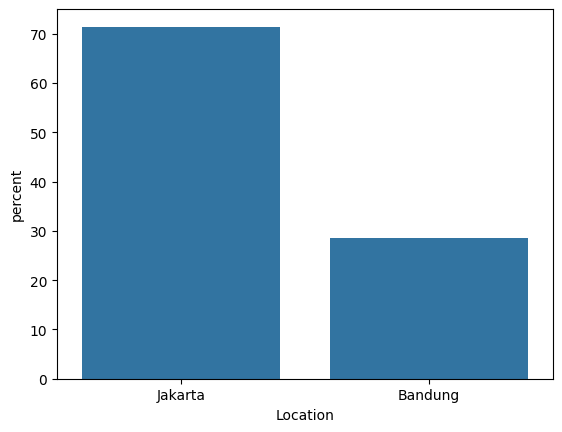

In [98]:
sns.countplot(data=df, x='Location', stat='percent')
plt.show()

This is not fair because around 70% are users from Jakarta

## Games Product, Music Product, Education Product, Video Product, and Use MyApp
`No internet service` and `No` means the same thing which is the use doesn't use the internet for the specified **product** or **app**.

In [99]:
if 1 and 2 and 4:
    print("ak")

ak


In [101]:
# change label of product and app
def preprocess_data(df):
    
    def check_internet_service(row): 
        if row['Games Product'] == "No internet service"\
            and (row['Music Product'] == "No internet service")\
            and (row['Education Product'] == "No internet service")\
            and (row['Video Product'] == "No internet service")\
            and (row['Use MyApp'] == "No internet service"):
            return "Don't use internet"
        else: return "Use internet"
    
    df=df.copy()
    df['Internet Service'] = df.apply(lambda x: check_internet_service(x), axis=1)
    
    prod_app_map = {
        "Yes": 1,
        "No": 0,
        "No internet service": 0,
    }
    df['Games Product'] = df['Games Product'].replace(prod_app_map)
    df['Music Product'] = df['Music Product'].replace(prod_app_map)
    df['Education Product'] = df['Education Product'].replace(prod_app_map)
    df['Video Product'] = df['Video Product'].replace(prod_app_map)
    df['Use MyApp'] = df['Use MyApp'].replace(prod_app_map)

    df['Churn'] = df['Churn Label'].map({"Yes": "1", "No": "0"}).astype(int)


    
    df['Total Charges'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']
    return df

df = preprocess_data(df_ori)

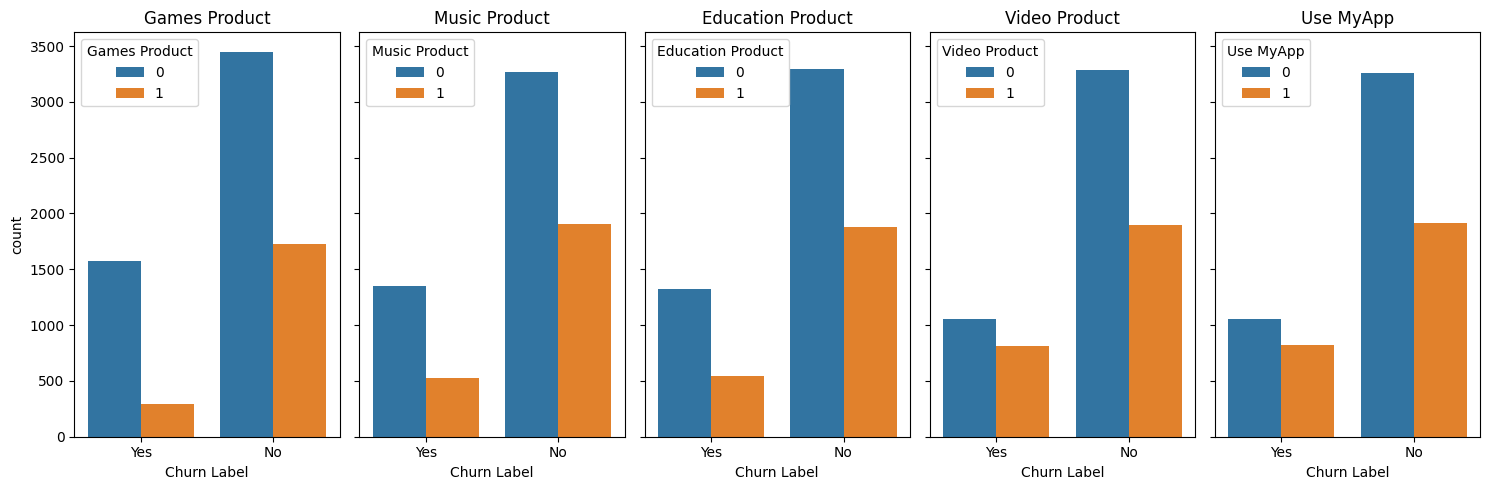

In [102]:
cols = ["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]
fig, ax = plt.subplots(ncols=len(cols), figsize=(15, 5), sharey=True)
for i, c in enumerate(cols):
    sns.countplot(data=df, x='Churn Label', hue=c, ax=ax[i])
    ax[i].set_title(c)
fig.tight_layout()

Churned users use `MyApp` and `Video Product`. Lets dig deeper.

High End Device Users has more likely change to churn

## Internet Service

In [103]:
df['Internet Service'].unique()

array(['Use internet', "Don't use internet"], dtype=object)

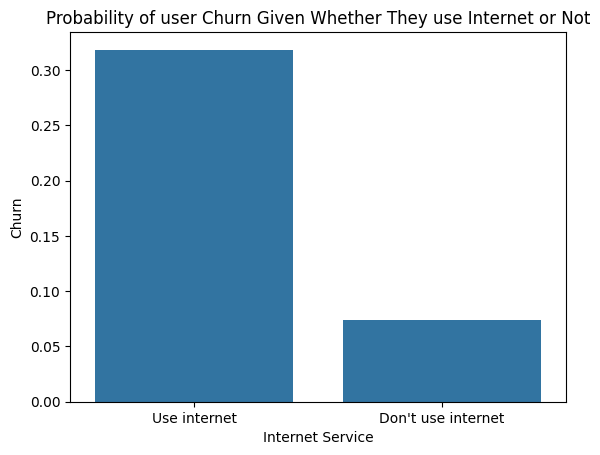

In [111]:
sns.barplot(data=df, x='Internet Service', y="Churn", errorbar=None)
plt.title("Probability of user Churn Given Whether They use Internet or Not")
plt.show()

30% change of churing if the user uses the internet. Probabily there's a problem with the internet service; slow, etc.

## Payment Method

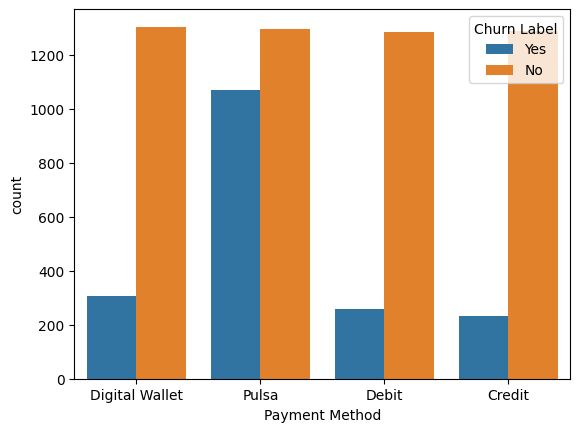

In [17]:
sns.countplot(data=df, x='Payment Method', hue='Churn Label')
plt.show()

In [28]:
churn_payment_method = df.pivot_table(columns="Payment Method", index="Churn", values="Customer ID", aggfunc="count", margins=True)
churn_payment_method /= churn_payment_method.loc['All', :]
churn_payment_method = churn_payment_method.loc[churn_payment_method.index != 'All', churn_payment_method.columns != 'All']
churn_payment_method

Payment Method,Credit,Debit,Digital Wallet,Pulsa
Churn,,,,
0,0.847569,0.832902,0.808933,0.547146
1,0.152431,0.167098,0.191067,0.452854


If you users buy using pulsa, 45% change they will churn

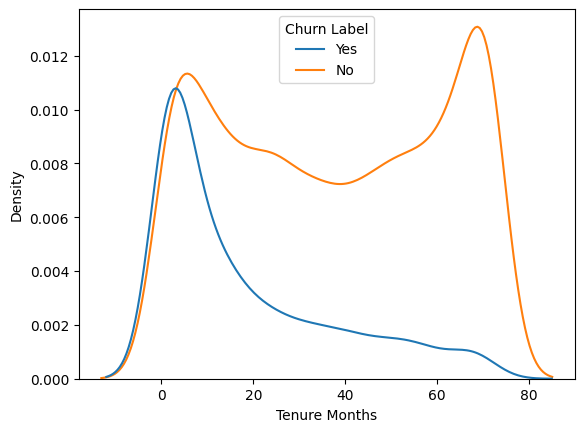

In [30]:
sns.kdeplot(data=df, x='Tenure Months', hue='Churn Label')
plt.show()

Low Tenure Months has a high change of churned

In [30]:
df.pivot_table(index="Churn", values="Monthly Purchase (Thou. IDR)", aggfunc="mean")

,Monthly Purchase (Thou. IDR)
Churn,
0,79.644661
1,96.773732


Users churn because of monthly payment that they have to spend is more than the un-churned. But does it make sense. Let's take a look at the distribution

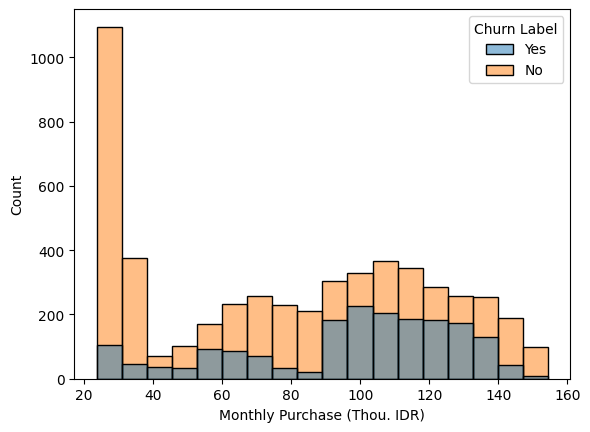

In [16]:
sns.histplot(data=df, x='Monthly Purchase (Thou. IDR)', hue='Churn Label')
plt.show()

Customer also churned for low monhtly purchases, but mose of the churned users spend between Rp 90,000.00 - Rp 140,000.00 a month.

In [25]:
df['Total Charges'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']

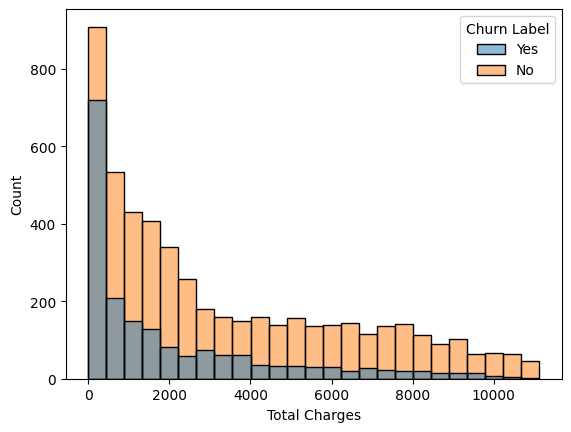

In [28]:
sns.histplot(data=df, x='Total Charges', hue='Churn Label')
plt.show()